In [1]:
import numpy as np
import cv2
from  matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def cv_show(name, image):
    image = image[:,:,::-1] 
    plt.title(name)
    plt.imshow(image)
    plt.show()

In [3]:
def detectAndDescribe(image):
    # 将彩色图片转换成灰度图
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 建立SIFT生成器
    descriptor = cv2.SIFT_create()
    # 检测SIFT特征点，并计算描述子
    (kps, features) = descriptor.detectAndCompute(image, None)
    # 将结果转换成NumPy数组
    kps = np.float32([kp.pt for kp in kps])
    # 返回特征点集，及对应的描述特征
    return (kps, features)

In [4]:
def matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio = 0.75, reprojThresh = 4.0):
    # 建立暴力匹配器
    matcher = cv2.BFMatcher()
    # 使用KNN检测来自A、B图的SIFT特征匹配对，K=2
    rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
    matches = []
    for m in rawMatches:
        # 当最近距离跟次近距离的比值小于ratio值时，保留此匹配对
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        # 存储两个点在featuresA, featuresB中的索引值
            matches.append((m[0].trainIdx, m[0].queryIdx))
        # 当筛选后的匹配对大于4时，计算视角变换矩阵
    if len(matches) > 4:
        # 获取匹配对的点坐标
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])
        # 计算视角变换矩阵
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
        # 返回结果
        return (matches, H, status)
    # 如果匹配对小于4时，返回None
    return None

In [5]:
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # 初始化可视化图片，将A、B图左右连接到一起
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB
    # 联合遍历，画出匹配对
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        # 当点对匹配成功时，画到可视化图上
        if s == 1:
            # 画出匹配对
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
    cv_show("MATCHES", vis)
    # 返回可视化结果
    return vis

In [6]:
def stitch(imageA,imageB, ratio=0.75, reprojThresh=4.0,showMatches=False):
    #检测A、B图片的SIFT关键特征点，并计算特征描述子
    (kpsA, featuresA) = detectAndDescribe(imageA)
    (kpsB, featuresB) = detectAndDescribe(imageB)
    # 匹配两张图片的所有特征点，返回匹配结果
    M = matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)
    # 如果返回结果为空，没有匹配成功的特征点，退出算法
    if M is None:
        return None
    # 否则，提取匹配结果
    # H是3x3视角变换矩阵
    (matches, H, status) = M
    # 将图片A进行视角变换，result是变换后图片
    result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
    # cv_show('result', result)
    # 将图片B传入result图片最左端
    result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
    # cv_show('result', result)
    # 检测是否需要显示图片匹配
    if showMatches:
        # 生成匹配图片
        vis = drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
        # 返回结果
        return (result, vis)
    # 返回匹配结果
    return result

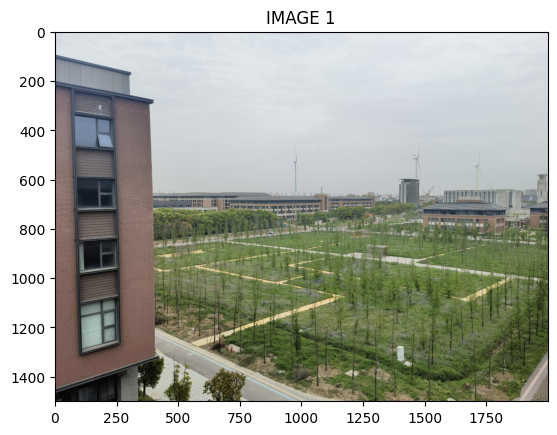

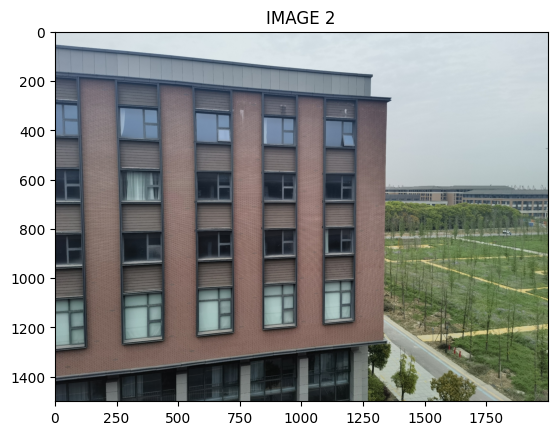

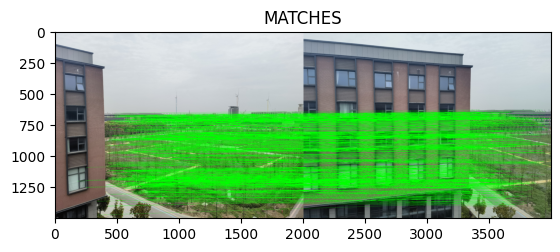

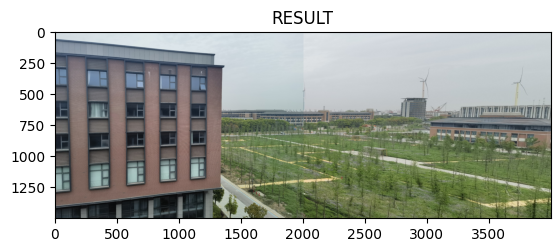

True

In [7]:
# 读取图像
image1 = cv2.imread('img1.jpg')
image2 = cv2.imread('img2.jpg')
cv_show("IMAGE 1", image1)
cv_show("IMAGE 2", image2)
# 计算SIFT特征点和特征向量
(kps1, features1) = detectAndDescribe(image1)
(kps2, features2) = detectAndDescribe(image2)
# 基于最近邻和随机取样一致性得到一个单应性矩阵
(matches,H,status) = matchKeypoints(kps1, kps2, features1, features2)
# 绘制匹配结果
drawMatches(image1, image2, kps1, kps2, matches, status)
# 拼接
res = stitch(image1, image2)
cv_show("RESULT", res)
cv2.imwrite('result.jpg', res) 